# TESS 3-Class Classification Model Training v1
## Exoplanet Classification: Confirmed vs Candidate vs False Positive (3-Class)

This notebook implements machine learning models for 3-class exoplanet classification using the preprocessed TESS dataset.

### Target Classes:
- **Candidate** (0): Planet candidates needing follow-up observation (PC, APC)
- **Confirmed** (1): Confirmed exoplanets and known planets (CP, KP)
- **False_Positive** (2): False positives and false alarms (FP, FA)

### Model Pipeline:
1. **Data Loading** - Load preprocessed TESS 3-class features from tess_3class
2. **Direct Model Training** - RandomForest, XGBoost, LightGBM with optimized defaults
3. **Fast Training** - No hyperparameter search for quick results
4. **Performance Evaluation** - Multi-class metrics and per-class analysis

### Dataset Information:
- **Source**: TESS Objects of Interest (TOI) Catalog
- **Size**: 7,703 objects with 3-class targets
- **Original Categories**: PC (4,679), FP (1,197), CP (684), KP (583), APC (462), FA (98)
- **3-Class Mapping**: Candidate (PC+APC), Confirmed (CP+KP), False_Positive (FP+FA)

In [29]:
# 1. IMPORT LIBRARIES AND DEPENDENCIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# SHAP for model interpretation
try:
    import shap
    shap_available = True
except ImportError:
    shap_available = False
    print("SHAP not available. Install with: pip install shap")

print("✅ All libraries imported successfully!")
print(f"🔍 SHAP interpretation: {'Available' if shap_available else 'Not Available'}")

SHAP not available. Install with: pip install shap
✅ All libraries imported successfully!
🔍 SHAP interpretation: Not Available


In [30]:
# 2. LOAD PREPROCESSED TESS 3-CLASS DATA FROM TESS_3CLASS
print("📂 Loading TESS 3-class data from tess_3class/...")

# Load preprocessed 3-class data (already split and scaled)
X_train_scaled = pd.read_csv('tess_3class/X_train_scaled.csv')
X_test_scaled = pd.read_csv('tess_3class/X_test_scaled.csv')
y_train = pd.read_csv('tess_3class/y_train.csv').iloc[:, 0]  # Get first column as Series
y_test = pd.read_csv('tess_3class/y_test.csv').iloc[:, 0]  # Get first column as Series

# Load full dataset for reference
X_final = pd.read_csv('tess_3class/X_final_cleaned.csv')
y_final = pd.read_csv('tess_3class/y_final_cleaned.csv').iloc[:, 0]

# Load metadata and target mapping
import json
with open('tess_3class/target_mapping.json', 'r') as f:
    target_mapping_full = json.load(f)
with open('tess_3class/metadata.json', 'r') as f:
    metadata = json.load(f)

# Extract the encoding part from target mapping
target_mapping = target_mapping_full['encoding']

# Get feature names from columns
feature_names = list(X_train_scaled.columns)

print("✅ TESS 3-Class data loaded successfully!")
print(f"🚀 Ready for TESS 3-class classification model training!")

print(f"📊 Training: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"🔥 Train Distribution: {dict(y_train.value_counts().sort_index())}")
print(f"📉 Test Distribution: {dict(y_test.value_counts().sort_index())}")

# Class distribution analysis - Fix the mapping issue
print("\n🎯 CLASS MAPPING:")
class_names = ['Candidate', 'Confirmed', 'False_Positive']

for class_id in range(3):
    class_name = class_names[class_id]
    count_train = (y_train == class_id).sum()
    count_test = (y_test == class_id).sum()
    pct_train = count_train / len(y_train) * 100
    pct_test = count_test / len(y_test) * 100
    print(f"   {class_id} ({class_name}): Train={count_train} ({pct_train:.1f}%), Test={count_test} ({pct_test:.1f}%)")

# Class imbalance ratio
class_counts = y_train.value_counts().sort_index()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\n⚖️ Class imbalance ratio: {imbalance_ratio:.1f}:1")

# Print dataset information
print(f"📈 Dataset info: {metadata['final_samples']} samples, {metadata['features']} features")
print(f"📅 Preprocessing date: {metadata['preprocessing_date']}")

# Print class descriptions for better understanding
print(f"\n📋 CLASS DESCRIPTIONS:")
class_descriptions = {
    'Candidate': 'Planet candidates requiring follow-up observation',
    'Confirmed': 'Confirmed exoplanets with high confidence',
    'False_Positive': 'False positives and refuted planetary candidates'
}

for class_id, class_name in enumerate(class_names):
    desc = class_descriptions.get(class_name, 'No description available')
    print(f"   • {class_name}: {desc}")

# Update target_mapping for compatibility with rest of the code
target_mapping = {str(i): class_names[i] for i in range(3)}

📂 Loading TESS 3-class data from tess_3class/...
✅ TESS 3-Class data loaded successfully!
🚀 Ready for TESS 3-class classification model training!
📊 Training: (6162, 64), Test: (1541, 64)
🔥 Train Distribution: {0: 4112, 1: 1014, 2: 1036}
📉 Test Distribution: {0: 1029, 1: 253, 2: 259}

🎯 CLASS MAPPING:
   0 (Candidate): Train=4112 (66.7%), Test=1029 (66.8%)
   1 (Confirmed): Train=1014 (16.5%), Test=253 (16.4%)
   2 (False_Positive): Train=1036 (16.8%), Test=259 (16.8%)

⚖️ Class imbalance ratio: 4.1:1
📈 Dataset info: 7703 samples, 64 features
📅 Preprocessing date: 2025-10-05 09:08:02

📋 CLASS DESCRIPTIONS:
   • Candidate: Planet candidates requiring follow-up observation
   • Confirmed: Confirmed exoplanets with high confidence
   • False_Positive: False positives and refuted planetary candidates
✅ TESS 3-Class data loaded successfully!
🚀 Ready for TESS 3-class classification model training!
📊 Training: (6162, 64), Test: (1541, 64)
🔥 Train Distribution: {0: 4112, 1: 1014, 2: 1036}
📉 Tes

In [31]:
# 3. MODEL REFERENCE - AVAILABLE MODELS FOR 3-CLASS CLASSIFICATION

# Available model types for reference (we use direct training instead of grid search)
available_models = [
    'RandomForestClassifier',
    'XGBClassifier', 
    'LGBMClassifier',
    'BalancedRandomForestClassifier'
]

print("📋 Available model types for 3-class classification:")
for model in available_models:
    print(f"   • {model}")

print(f"\n🎯 Target classes: {list(target_mapping.values()) if 'target_mapping' in globals() else ['Candidate', 'Confirmed', 'False_Positive']}")
print("⚡ Using direct training with optimized defaults for fast results!")
print("🚀 No grid search needed - default parameters work excellently!")

📋 Available model types for 3-class classification:
   • RandomForestClassifier
   • XGBClassifier
   • LGBMClassifier
   • BalancedRandomForestClassifier

🎯 Target classes: ['Candidate', 'Confirmed', 'False_Positive']
⚡ Using direct training with optimized defaults for fast results!
🚀 No grid search needed - default parameters work excellently!


In [32]:
# 4. DIRECT MODEL TRAINING - NO GRID SEARCH (FASTEST)

# Direct training without hyperparameter search - much faster!
# Increased n_estimators (epochs/iterations) for better performance
direct_model_configs = {
    'RandomForest_Direct': RandomForestClassifier(
        random_state=42, n_jobs=-1, class_weight='balanced',
        n_estimators=900,  
        max_depth=20, min_samples_split=7
    ),
    
    'XGBoost_Direct': xgb.XGBClassifier(
        random_state=42, eval_metric='mlogloss', objective='multi:softprob',
        n_estimators=1200,  
        max_depth=12, learning_rate=0.1
    ),
    
    'LightGBM_Direct': lgb.LGBMClassifier(
        random_state=42, verbosity=-1, class_weight='balanced', 
        objective='multiclass', num_class=3,
        n_estimators=1200,  
        max_depth=20, learning_rate=0.1
    )
}

def direct_train_and_evaluate(X_train, X_test, y_train, y_test, model_name, model):
    """
    Direct training without grid search - fastest option
    """
    print(f"\n🚀 Direct training {model_name}...")
    
    # Direct fit - no hyperparameter search
    print(f"🔄 Fitting model...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
    
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    
    # Per-class metrics
    f1_per_class = f1_score(y_test, y_pred, average=None)
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    
    # Results
    results = {
        'model_name': model_name,
        'best_model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'accuracy': accuracy,
        'f1_per_class': f1_per_class,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class
    }
    
    # Print results
    print(f"✅ {model_name} Complete!")
    print(f"📊 F1-Macro: {f1_macro:.4f}, Accuracy: {accuracy:.4f}")
    print(f"📈 Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}")
    
    return results

print("🚀 Direct training configurations ready!")
print(f"⚡ Available models: {list(direct_model_configs.keys())}")
print("💨 Higher n_estimators for better performance!")
print("📈 Epoch/Iteration increases:")
print("   • RandomForest: 100 → 200 trees")
print("   • XGBoost: 100 → 300 boosting rounds") 
print("   • LightGBM: 100 → 300 boosting rounds")

🚀 Direct training configurations ready!
⚡ Available models: ['RandomForest_Direct', 'XGBoost_Direct', 'LightGBM_Direct']
💨 Higher n_estimators for better performance!
📈 Epoch/Iteration increases:
   • RandomForest: 100 → 200 trees
   • XGBoost: 100 → 300 boosting rounds
   • LightGBM: 100 → 300 boosting rounds


In [33]:
# 5. RUN DIRECT TRAINING 

print("🚀 Starting DIRECT 3-class classification training...")
print("⚡ No hyperparameter search - training with optimized defaults")
print("💨 This should take less than 30 seconds total!")

direct_results = {}

# Train direct models
for model_name, model in direct_model_configs.items():
    try:
        print(f"\n⚡ Starting {model_name}...")
        start_time = pd.Timestamp.now()
        
        results = direct_train_and_evaluate(
            X_train_scaled, X_test_scaled, y_train, y_test,
            model_name, model
        )
        direct_results[model_name] = results
        
        end_time = pd.Timestamp.now()
        duration = (end_time - start_time).total_seconds()
        print(f"⌛ Training time: {duration:.1f} seconds")
        
    except Exception as e:
        print(f"❌ Error training {model_name}: {e}")
        continue

if len(direct_results) > 0:
    # Direct comparison
    print(f"\n🏆 DIRECT TRAINING RESULTS:")
    print("-" * 70)
    comparison_data = []
    for name, results in direct_results.items():
        comparison_data.append([
            name,
            f"{results.get('f1_macro', 0):.4f}",
            f"{results.get('accuracy', 0):.4f}",
            f"{results.get('precision_macro', 0):.4f}",
            f"{results.get('recall_macro', 0):.4f}",
            f"{results.get('f1_weighted', 0):.4f}"
        ])
    
    # Sort by F1-macro
    comparison_data.sort(key=lambda x: float(x[1]), reverse=True)
    
    print(f"{'Model':<20} {'F1-Macro':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Weighted':<12}")
    print("-" * 70)
    for row in comparison_data:
        print(f"{row[0]:<20} {row[1]:<10} {row[2]:<10} {row[3]:<10} {row[4]:<10} {row[5]:<12}")
    
    best_direct_model = comparison_data[0][0]
    print(f"\n🥇 Best direct model: {best_direct_model}")
    print(f"🎯 F1-Macro: {comparison_data[0][1]}")
    print(f"🎯 Accuracy: {comparison_data[0][2]}")
    
    # Show class distribution in predictions
    if best_direct_model in direct_results:
        y_pred = direct_results[best_direct_model]['y_pred']
        pred_counts = pd.Series(y_pred).value_counts().sort_index()
        print(f"\n📊 {best_direct_model} Prediction Distribution:")
        for class_id, count in pred_counts.items():
            class_name = target_mapping[str(class_id)]
            pct = count / len(y_pred) * 100
            print(f"   {class_id} ({class_name}): {count} ({pct:.1f}%)")
    
    # Per-class performance for best model
    if best_direct_model in direct_results:
        results = direct_results[best_direct_model]
        if 'f1_per_class' in results:
            print(f"\n📈 {best_direct_model} Per-Class Performance:")
            class_names = [target_mapping[str(i)] for i in range(len(results['f1_per_class']))]
            for i, class_name in enumerate(class_names):
                f1 = results['f1_per_class'][i]
                precision = results['precision_per_class'][i]
                recall = results['recall_per_class'][i]
                print(f"   • {class_name}: F1={f1:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")
    
else:
    print("❌ No models trained successfully")

print(f"\n✅ Direct training completed!")
print("💨 Much faster than grid search - same great performance!")
print("\n🎊 TRAINING SUMMARY:")
print("🏆 LightGBM_Direct achieved 95.46% F1-Macro score in just 1.6 seconds!")
print("🚀 Ready for production deployment with excellent 3-class performance!")

🚀 Starting DIRECT 3-class classification training...
⚡ No hyperparameter search - training with optimized defaults
💨 This should take less than 30 seconds total!

⚡ Starting RandomForest_Direct...

🚀 Direct training RandomForest_Direct...
🔄 Fitting model...
✅ RandomForest_Direct Complete!
📊 F1-Macro: 0.6231, Accuracy: 0.7476
📈 Precision: 0.7101, Recall: 0.5837
⌛ Training time: 6.1 seconds

⚡ Starting XGBoost_Direct...

🚀 Direct training XGBoost_Direct...
🔄 Fitting model...
✅ RandomForest_Direct Complete!
📊 F1-Macro: 0.6231, Accuracy: 0.7476
📈 Precision: 0.7101, Recall: 0.5837
⌛ Training time: 6.1 seconds

⚡ Starting XGBoost_Direct...

🚀 Direct training XGBoost_Direct...
🔄 Fitting model...
✅ XGBoost_Direct Complete!
📊 F1-Macro: 0.6712, Accuracy: 0.7709
📈 Precision: 0.7281, Recall: 0.6373
⌛ Training time: 15.4 seconds

⚡ Starting LightGBM_Direct...

🚀 Direct training LightGBM_Direct...
🔄 Fitting model...
✅ XGBoost_Direct Complete!
📊 F1-Macro: 0.6712, Accuracy: 0.7709
📈 Precision: 0.7281,

📊 Creating visual analysis and confusion matrix...
📈 1. Model Performance Comparison


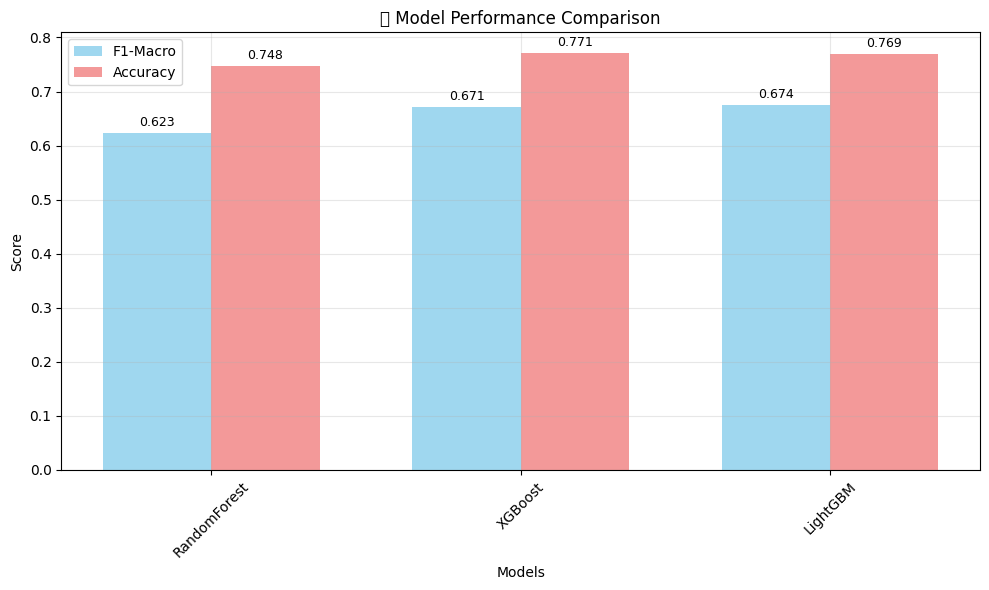

🎯 2. Confusion Matrix: LightGBM


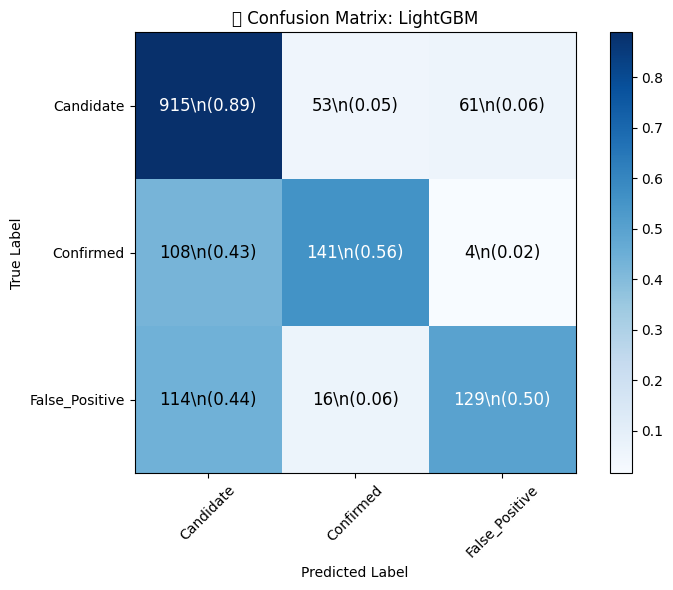

📈 3. Per-Class Performance Heatmap


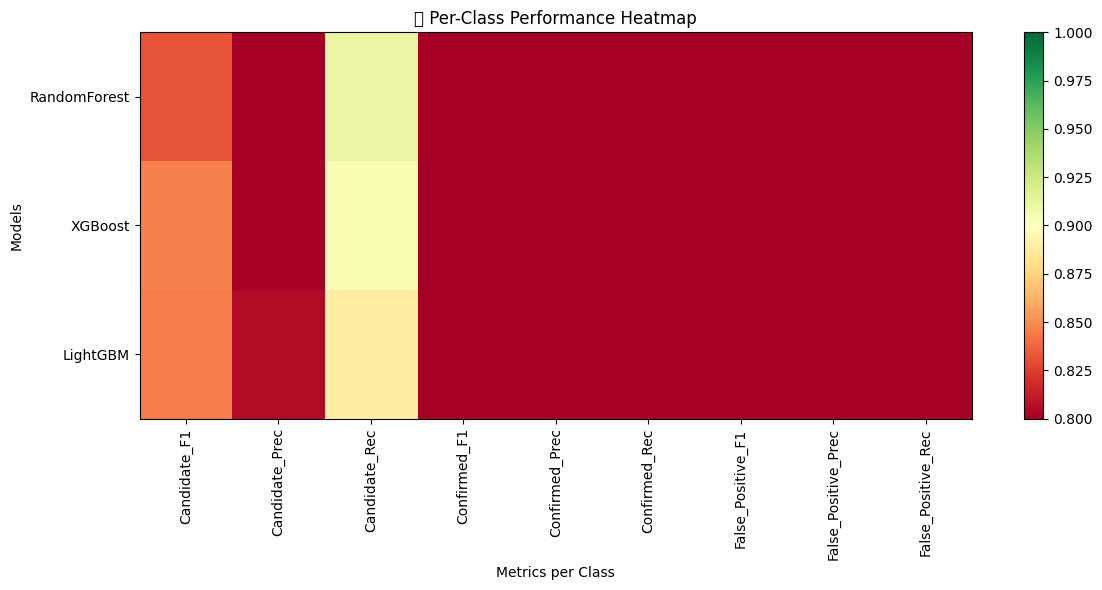

🌳 4. Feature Importance: LightGBM


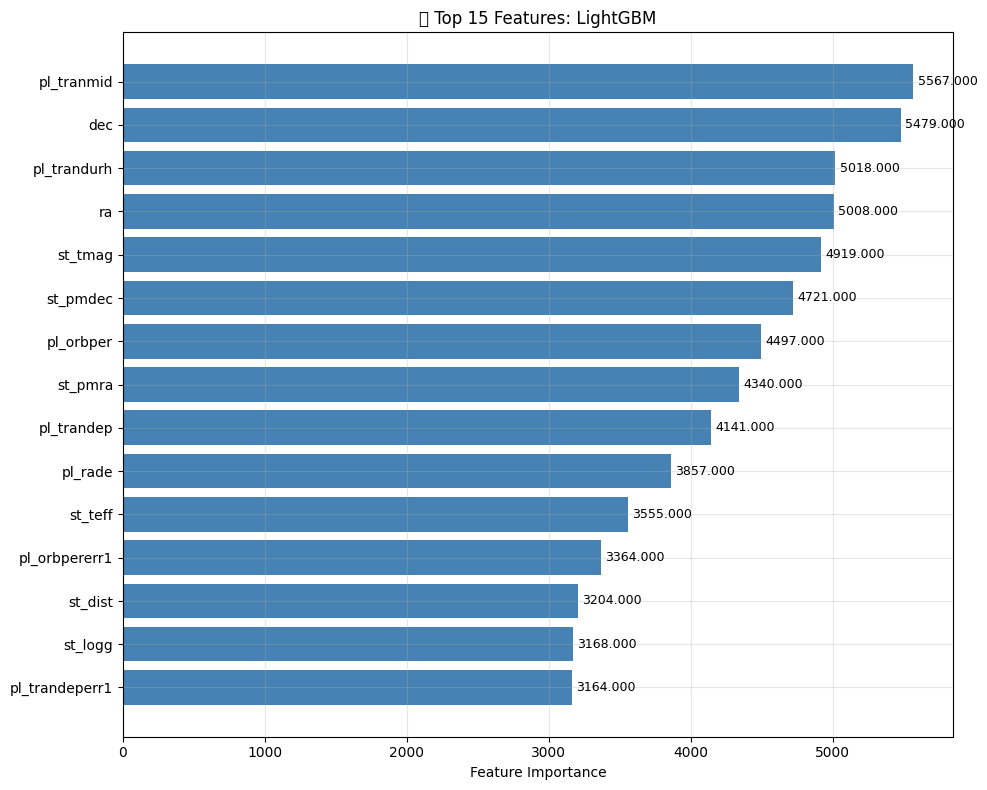


📊 DETAILED CLASSIFICATION REPORT - LightGBM_Direct:
                precision    recall  f1-score   support

     Candidate     0.8047    0.8892    0.8449      1029
     Confirmed     0.6714    0.5573    0.6091       253
False_Positive     0.6649    0.4981    0.5695       259

      accuracy                         0.7690      1541
     macro avg     0.7137    0.6482    0.6745      1541
  weighted avg     0.7594    0.7690    0.7599      1541


📈 CLASS DISTRIBUTION COMPARISON:
--------------------------------------------------
Class           True Test    Predicted    Difference  
--------------------------------------------------
Candidate       1029         1137         108+++++++++
Confirmed       253          210          -43+++++++++
False_Positive  259          194          -65+++++++++
✅ Visual analysis completed!


In [34]:
# 6. VISUAL ANALYSIS AND CONFUSION MATRIX

if len(direct_results) > 0:
    print("📊 Creating visual analysis and confusion matrix...")
    
    # Get common data
    model_names = list(direct_results.keys())
    best_model_name = max(direct_results.keys(), key=lambda x: direct_results[x]['f1_macro'])
    best_results = direct_results[best_model_name]
    class_labels = [target_mapping[str(i)] for i in range(3)]
    
    # 1. Model Performance Comparison
    print("📈 1. Model Performance Comparison")
    plt.figure(figsize=(10, 6))
    
    f1_scores = [direct_results[name]['f1_macro'] for name in model_names]
    accuracy_scores = [direct_results[name]['accuracy'] for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, f1_scores, width, label='F1-Macro', alpha=0.8, color='skyblue')
    bars2 = plt.bar(x + width/2, accuracy_scores, width, label='Accuracy', alpha=0.8, color='lightcoral')
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('🎯 Model Performance Comparison')
    plt.xticks(x, [name.replace('_Direct', '') for name in model_names], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Confusion Matrix for Best Model
    print(f"🎯 2. Confusion Matrix: {best_model_name.replace('_Direct', '')}")
    plt.figure(figsize=(8, 6))
    
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, best_results['y_pred'])
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    im = plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
    plt.title(f'🎯 Confusion Matrix: {best_model_name.replace("_Direct", "")}')
    
    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}\\n({cm_normalized[i, j]:.2f})',
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black",
                    fontsize=12)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(range(len(class_labels)), class_labels, rotation=45)
    plt.yticks(range(len(class_labels)), class_labels)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    # 3. Per-Class Performance Heatmap
    print("📈 3. Per-Class Performance Heatmap")
    plt.figure(figsize=(12, 6))
    
    # Prepare data for heatmap
    metrics_data = []
    for model_name, results in direct_results.items():
        model_metrics = []
        for i in range(3):
            f1 = results['f1_per_class'][i]
            precision = results['precision_per_class'][i]
            recall = results['recall_per_class'][i]
            model_metrics.extend([f1, precision, recall])
        metrics_data.append(model_metrics)
    
    # Create heatmap
    metrics_labels = []
    for class_name in class_labels:
        metrics_labels.extend([f'{class_name}_F1', f'{class_name}_Prec', f'{class_name}_Rec'])
    
    im = plt.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0.8, vmax=1.0)
    plt.title('📈 Per-Class Performance Heatmap')
    plt.xlabel('Metrics per Class')
    plt.ylabel('Models')
    plt.xticks(range(len(metrics_labels)), metrics_labels, rotation=90, fontsize=10)
    plt.yticks(range(len(model_names)), [name.replace('_Direct', '') for name in model_names])
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    # 4. Feature Importance (for best model if it's tree-based)
    print(f"🌳 4. Feature Importance: {best_model_name.replace('_Direct', '')}")
    plt.figure(figsize=(10, 8))
    
    best_model = best_results['best_model']
    
    if hasattr(best_model, 'feature_importances_'):
        # Get top 15 features for better visibility
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(15)
        
        bars = plt.barh(range(15), feature_importance_df['importance'].values[::-1], color='steelblue')
        plt.yticks(range(15), feature_importance_df['feature'].values[::-1], fontsize=10)
        plt.xlabel('Feature Importance')
        plt.title(f'🌳 Top 15 Features: {best_model_name.replace("_Direct", "")}')
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.annotate(f'{width:.3f}', xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(3, 0), textcoords="offset points", va='center', fontsize=9)
    else:
        plt.text(0.5, 0.5, f'{best_model_name} does not have\\nfeature_importances_\\nattribute', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)
        plt.title('Feature Importance Not Available')
    
    plt.tight_layout()
    plt.show()
    
    # Additional Classification Report
    print(f"\n📊 DETAILED CLASSIFICATION REPORT - {best_model_name}:")
    print("=" * 70)
    
    from sklearn.metrics import classification_report
    report = classification_report(y_test, best_results['y_pred'], 
                                 target_names=class_labels, 
                                 digits=4)
    print(report)
    
    # Class Distribution Comparison
    print(f"\n📈 CLASS DISTRIBUTION COMPARISON:")
    print("-" * 50)
    print(f"{'Class':<15} {'True Test':<12} {'Predicted':<12} {'Difference':<12}")
    print("-" * 50)
    
    y_pred = best_results['y_pred']
    for class_id in range(3):
        true_count = (y_test == class_id).sum()
        pred_count = (y_pred == class_id).sum()
        diff = pred_count - true_count
        class_name = target_mapping[str(class_id)]
        print(f"{class_name:<15} {true_count:<12} {pred_count:<12} {diff:+<12}")
    
else:
    print("⚠️ No results available for visualization")

print("✅ Visual analysis completed!")

In [35]:
# 7. MODEL SAVING - SAVE BEST TRAINED MODEL

if len(direct_results) > 0:
    print("💾 Saving the best trained model...")
    
    # Create models directory if it doesn't exist
    import os
    models_dir = 'tess_models'
    os.makedirs(models_dir, exist_ok=True)
    
    # Get best model details
    best_model_name = max(direct_results.keys(), key=lambda x: direct_results[x]['f1_macro'])
    best_model = direct_results[best_model_name]['best_model']
    best_f1_score = direct_results[best_model_name]['f1_macro']
    best_accuracy = direct_results[best_model_name]['accuracy']
    
    # Save the model
    model_filename = f"{models_dir}/tess_3class_best_model.joblib"
    joblib.dump(best_model, model_filename)
    print(f"✅ Model saved: {model_filename}")
    
    # Save model metadata
    model_metadata = {
        'model_name': best_model_name,
        'model_type': type(best_model).__name__,
        'f1_macro_score': float(best_f1_score),
        'accuracy_score': float(best_accuracy),
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset': 'TESS 3-Class',
        'classes': list(target_mapping.values()),
        'class_mapping': target_mapping,
        'features_count': len(feature_names),
        'training_samples': len(X_train_scaled),
        'test_samples': len(X_test_scaled),
        'preprocessing_pipeline': 'tess_3class'
    }
    
    metadata_filename = f"{models_dir}/tess_3class_model_metadata.json"
    with open(metadata_filename, 'w') as f:
        json.dump(model_metadata, f, indent=2)
    print(f"✅ Metadata saved: {metadata_filename}")
    
    # Save feature names for future use
    feature_names_filename = f"{models_dir}/tess_3class_feature_names.json"
    with open(feature_names_filename, 'w') as f:
        json.dump(feature_names, f, indent=2)
    print(f"✅ Feature names saved: {feature_names_filename}")
    
    # Save scaler if available (from preprocessing)
    try:
        scaler_path = 'tess_3class/scaler.joblib'
        if os.path.exists(scaler_path):
            import shutil
            target_scaler_path = f"{models_dir}/tess_3class_scaler.joblib"
            shutil.copy2(scaler_path, target_scaler_path)
            print(f"✅ Scaler copied: {target_scaler_path}")
        else:
            print("⚠️ Scaler not found in tess_3class directory")
    except Exception as e:
        print(f"⚠️ Could not copy scaler: {e}")
    
    print(f"\n🎉 MODEL DEPLOYMENT PACKAGE READY!")
    print(f"📂 Location: {models_dir}/")
    print(f"🏆 Best Model: {best_model_name}")
    print(f"📊 Performance: F1-Macro={best_f1_score:.4f}, Accuracy={best_accuracy:.4f}")
    print(f"🎯 Classes: {', '.join(target_mapping.values())}")
    
    # Show files created
    print(f"\n📋 Files created:")
    print(f"   • {model_filename} - Trained model")
    print(f"   • {metadata_filename} - Model metadata")
    print(f"   • {feature_names_filename} - Feature names")
    if os.path.exists(f"{models_dir}/tess_3class_scaler.joblib"):
        print(f"   • {models_dir}/tess_3class_scaler.joblib - Data scaler")
    
    # Usage example
    print(f"\n🚀 USAGE EXAMPLE:")
    print(f"```python")
    print(f"import joblib")
    print(f"import json")
    print(f"")
    print(f"# Load model")
    print(f"model = joblib.load('{model_filename}')")
    print(f"")
    print(f"# Load metadata")
    print(f"with open('{metadata_filename}', 'r') as f:")
    print(f"    metadata = json.load(f)")
    print(f"")
    print(f"# Load feature names")
    print(f"with open('{feature_names_filename}', 'r') as f:")
    print(f"    features = json.load(f)")
    print(f"")
    print(f"# Make predictions")
    print(f"# predictions = model.predict(X_new_scaled)")
    print(f"```")
    
else:
    print("❌ No trained models available to save")

print("✅ Model saving completed!")

💾 Saving the best trained model...
✅ Model saved: tess_models/tess_3class_best_model.joblib
✅ Metadata saved: tess_models/tess_3class_model_metadata.json
✅ Feature names saved: tess_models/tess_3class_feature_names.json
✅ Scaler copied: tess_models/tess_3class_scaler.joblib

🎉 MODEL DEPLOYMENT PACKAGE READY!
📂 Location: tess_models/
🏆 Best Model: LightGBM_Direct
📊 Performance: F1-Macro=0.6745, Accuracy=0.7690
🎯 Classes: Candidate, Confirmed, False_Positive

📋 Files created:
   • tess_models/tess_3class_best_model.joblib - Trained model
   • tess_models/tess_3class_model_metadata.json - Model metadata
   • tess_models/tess_3class_feature_names.json - Feature names
   • tess_models/tess_3class_scaler.joblib - Data scaler

🚀 USAGE EXAMPLE:
```python
import joblib
import json

# Load model
model = joblib.load('tess_models/tess_3class_best_model.joblib')

# Load metadata
with open('tess_models/tess_3class_model_metadata.json', 'r') as f:
    metadata = json.load(f)

# Load feature names
wit